In [1]:
# Loading Libraries

# Warning Librarires
import warnings 
warnings.filterwarnings("ignore")

# Scientific and Data Manipulation Libraries 
import re
import os
import math
import nltk
import gensim
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix

from nltk.corpus import stopwords

from bs4 import BeautifulSoup
%matplotlib inline



In [2]:
# Loading Data
!gdown --id 1xqbJqmCpQyQjv8f4xPW8ApUYwBuOcqRt --output train.csv
!gdown --id 1uuB0K00Yl4weUWrsilTLHzkERmpm5Oio --output test.csv
!gdown --id 1u6xKBfVHiawkNLfWZrlnpstd4j9q4Y5H --output sample.csv

# 
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
sample_data = pd.read_csv('sample.csv')

Downloading...
From: https://drive.google.com/uc?id=1xqbJqmCpQyQjv8f4xPW8ApUYwBuOcqRt
To: /content/train.csv
3.16MB [00:00, 102MB/s]
Downloading...
From: https://drive.google.com/uc?id=1uuB0K00Yl4weUWrsilTLHzkERmpm5Oio
To: /content/test.csv
100% 1.38M/1.38M [00:00<00:00, 90.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1u6xKBfVHiawkNLfWZrlnpstd4j9q4Y5H
To: /content/sample.csv
100% 8.69k/8.69k [00:00<00:00, 7.88MB/s]


In [3]:
train_data.head()

,ID,Text,Label
0,ID_AASHwXxg,Mwangonde: Khansala wachinyamata Akamati achi...,POLITICS
1,ID_AGoFySzn,MCP siidakhutire ndi kalembera Chipani cha Ma...,POLITICS
2,ID_AGrrkBGP,Bungwe la MANEPO Lapempha Boma Liganizire Anth...,HEALTH
3,ID_AIJeigeG,Ndale zogawanitsa miyambo zanyanya Si zachile...,POLITICS
4,ID_APMprMbV,Nanga wapolisi ataphofomoka? Masiku ano sichi...,LAW/ORDER


In [4]:
test_data.head()

,ID,Text
0,ID_ADHEtjTi,Abambo odzikhweza akuchuluka Kafukufuku wa ap...
1,ID_AHfJktdQ,Ambuye Ziyaye Ayamikira Aphunzitsi a Tilitonse...
2,ID_AUJIHpZr,Anatcheleza: Akundiopseza a gogo wanga Akundi...
3,ID_AUKYBbIM,Ulova wafika posauzana Adatenga digiri ya uph...
4,ID_AZnsVPEi,"Dzombe kukoma, koma Kuyambira makedzana, pant..."


In [5]:
train_data.shape , test_data.shape

((1436, 3), (620, 2))

In [6]:
sample_data.head()

,ID,Label
0,ID_sQaPRMWO,0
1,ID_TanclvfR,0
2,ID_CNbveyvk,0
3,ID_MclKMhyP,0
4,ID_rNrmXOGD,0


In [7]:
train_data.isnull().sum()

ID       0
Text     0
Label    0
dtype: int64

Counter({'POLITICS': 279, 'SOCIAL': 152, 'RELIGION': 147, 'LAW/ORDER': 136, 'SOCIAL ISSUES': 134, 'HEALTH': 127, 'ECONOMY': 86, 'FARMING': 78, 'SPORTS': 49, 'EDUCATION': 43, 'RELATIONSHIPS': 39, 'WILDLIFE/ENVIRONMENT': 36, 'OPINION/ESSAY': 26, 'LOCALCHIEFS': 25, 'CULTURE': 23, 'WITCHCRAFT': 16, 'MUSIC': 15, 'TRANSPORT': 11, 'ARTS AND CRAFTS': 7, 'FLOODING': 7})


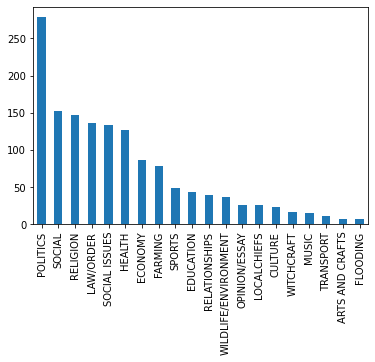

In [8]:
from collections import Counter
my_tags = Counter(train_data["Label"])
print(my_tags)
train_data.Label.value_counts().plot(kind='bar');

In [9]:
def print_plot(index):
    example = train_data[train_data.index == index][['Text', 'Label']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Label:', example[1])

print_plot(10)

 Kuchoka kwa Phoya kutisokoneza, atero ena Anthu mmadera osiyanasiyana msabatayi ati kuchoka kwa phungu wa chipani cholamula cha DPP mdera la ku mmawa mboma la Blantyre, Henry Phoya kwasiya mafunso ambiri mmitu yawo zomwe ati zingawasokoneze podzavota mchaka cha 2014.
 Anthuwa ati kuchokako kukusonyeza kuti kuchipani cholamula kwavunda zomwe ati zawachititsa kakasi kuti aone komwe angadzaponye voti yawo.
  Chisale watuluka nkumangidwanso  Sipakala waimitsa Nyumba ya Malamulo  Chakwera akwanitse malonjezoHRDC Koma katswiri wa za mbiri ya kale, Chijere Chirwa wati andale amachokachoka mzipani zawo kapena kuyambitsa chipani chawo kotero izi sizikuyenera kusokoneza anthu.
 Iye adati kuchoka kwa Phoya ukhale mwayi wa chipani cha DPP kuti apeze anthu ena atsopano omwe angamange chipanicho.
 Phoya Lachiwiri adalengeza kuti walowa chipani cha MCP. Iye adalengeza izi pa msonkhano wa atolankhani omwe udachitikira kunyumba ya mtsogoleri wa chipanichi, John Tembo.
 Pomwe Phoya amalengeza nkhaniyi,

In [10]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text
    
# train_data['Text'] = train_data['Text'].apply(clean_text)
# print_plot(10)

In [12]:
# X = []
# for i in range(train_data.shape[0]):
#     X.append(clean_text(train_data.iloc[i][1]))
# y = np.array(train_data["Label"])
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state = 42)


**Results on the Test Data**

In [13]:
X_train = []
X_test = []
for i in range(train_data.shape[0]):
    X_train.append(clean_text(train_data.iloc[i][1]))
y_train = np.array(train_data["Label"])

for i in range(test_data.shape[0]):
    X_test.append(clean_text(test_data.iloc[i][1]))

In [14]:
X_train[1:5]

['mcp siidakhutire ndi kalembera chipani cha malawi congress party mcp chati ngakhale ndime yachiwiri ya kalembera wa zisankho yayenda bwino poyerekeza ndi yoyamba mec iganizire zobwereranso mmaboma omwe yadutsamo kale kaamba koti anthu ambiri sadalembetse koma mkulu wa bungwe la malawi electoral commission mec jane ansah wati ndi wokhutira ndi mmene kalembera wayendera mgawo lachiwiri chakwera akwanitse malonjezohrdc masankhidwe nduna autsa mapiri pa chigwa malonjezo ayamba kuoneka ansah zinthu zayenda bwino kalembera wa mgawoli amachitikira mmaboma dowa ntchisi mchinji ndi nkhotakota malingana ndi lipoti lomwe mec yatulutsa mwa anthu 1 048 080 omwe limayembekezera kulembetsa anthu 875 138 ndiwo alembetsa chiwerengerochi chikutanthauza kuti mwa anthu 100 aliwonse omwe amayenera kulembetsa 83 ndiwo alembetsa zomwe zachititsa mlembi wa mcp maurice munthali kupempha mec kuti ibwererenso mmabomawo pali chosekerera apa tiyenera kuyandikira kwenikweni ku chiwerengero cha anthu omwe tidayene

In [15]:
print_plot(30)

 Tinkaimba limodzi kwaya Mdalitso suoneka pakudza munthu umangozindikira walandira mphatso koma osadziwa kuti yachoka kuti malingana ndi ntchito zomwe ukuchita monga momwe a mvula zakale adanenera kuti ntchito iliyonse ili ndi mphotho yake.
  Pa Wenela pasintha zedi  ANatchereza  Tidakumana ku sukulu ku Chiradzulu Kudzipereka komwe adachita Joseph Kaluwa ndi Victoria Mdala Kaluwa mchaka cha 2014 posankha kutumikira Mulungu mnjira ya kwaya patchalitchi ya mpingo wa chikatolika wa Don Bosco ku Lilongwe kudawalunjikitsira kumoyo wina wopambana.
 Awiriwa akuti amaimba kwaya limodzi ndipo kenako adagwa mchikondi atakhutitsidwa kuti iwo adalengedwa kuti adzakhale limodzi ngakhale kuti adabadwira ndi kukulira mbali ziwiri zosiyana za dziko lino la Malawi.
 Joseph ndi Victoria tsiku la ukwati wawo Ndinkasangalala tikamaimba ndipo ndikamamva mawu ake a nthetemya. China chomwe chidanditenga mtima nchakuti amakonda kupemphera ndi kutumikira kutchalitchi, adatero Joseph.
 Iye adati adayesetsa kuti

**Linear Support Vector Machine**

In [16]:
%%time
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)
y_pred = sgd.predict(X_test)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=Non...
                ('clf',
                 SGDClassifier(alpha=0.001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='hinge',
                      

In [18]:
y_pred[:10]

array(['SOCIAL ISSUES', 'RELIGION', 'RELATIONSHIPS', 'POLITICS', 'HEALTH',
       'RELIGION', 'POLITICS', 'ECONOMY', 'POLITICS', 'POLITICS'],
      dtype='<U20')

In [20]:
res = pd.DataFrame(y_pred)
res.index = test_data.ID
res.columns = ["Label"]
res.to_csv("prediction_results.csv",encoding="utf-8")